In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib.learn as learn
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone
import pytz
import math

# Load transcripts

In [5]:
est_tz = pytz.timezone('US/Eastern')
def utc_to_est(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(est_tz)
    return est_tz.normalize(local_dt)

In [6]:
def shift_time_according_to_closing_time(dt):
    if dt.hour >= 16:
        return dt + timedelta(days=1)
    return dt

In [7]:
def load_and_clean_transcripts():
    client = MongoClient('localhost', 27017)
    earnings_transcript_collection = client.python_import.earnings_transcript
    
    earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find()))
    earnings_transcript.drop('_id', axis=1, inplace=True)
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ'), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: utc_to_est(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
        lambda row: shift_time_according_to_closing_time(row['shifted_publishDate']), axis=1
    )
    earnings_transcript['publishDate_str'] = earnings_transcript.apply(
        lambda row: str(row['shifted_publishDate'].date()), axis=1
    )
    earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
    
    return earnings_transcript

In [8]:
earnings_transcript = load_and_clean_transcripts()

In [9]:
earnings_transcript.head(2)

,,publishDate,qAndAText,rawText,url,shifted_publishDate
tradingSymbol,publishDate_str,,,,,
A,2014-11-18,2014-11-17T22:25:00Z,,The following audio is from a conference call ...,https://seekingalpha.com/article/2675895-agile...,2014-11-18 17:25:00-05:00
AA,2014-10-09,2014-10-09T01:18:03Z,Operator [Operator instructions.] Our first qu...,Alcoa (NYSE: AA ) Q3 2014 Results Earnings Con...,https://seekingalpha.com/article/2549515-alcoa...,2014-10-09 21:18:03-04:00


In [10]:
earnings_transcript.tail(2)

publishDate  \
tradingSymbol publishDate_str                         
DISCA         2011-02-11       2011-02-11T18:34:47Z   
              2011-04-29       2011-04-28T21:00:00Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
DISCA         2011-02-11                                                           
              2011-04-29       Operator [Operator Instructions] And our first...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
DISCA         2011-02-11       Discovery Holding Co. CI A (NASDAQ: DISCA ) Q4...   
              2011-04-29       Discovery Communications (NASDAQ: DISCA ) Q1 2...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
DISCA         2011-02-11       https://seekingalpha.com/article/252356-discov...   
              2011-04-29       https://seekingalpha.com/article/280417-discov...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
DISCA         2011-02-11      2011-02-11 13:34:47-05:00  
              2011-04-29      2011-04-29 17:00:00-04:00

### Load all ticker data for transcripts

In [11]:
earnings_transcript.index.levels[0]

Index(['A', 'AA', 'AAN', 'AAON', 'AAP', 'AAPL', 'AAT', 'AAWW', 'ABAX', 'ABBV',
       ...
       'DG', 'DGII', 'DGX', 'DHI', 'DHR', 'DHX', 'DIN', 'DIOD', 'DIS',
       'DISCA'],
      dtype='object', name='tradingSymbol', length=198)

In [12]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        Applyer.label_to_check_against = None

        Applyer.label = '1day return'
        df['1day label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day label'] = df.apply(Applyer.label_calc, axis=1)

        Applyer.label_to_check_against = 'Std Dev'

        Applyer.label = '1day return'
        df['1day significant label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day significant label'] = df.apply(Applyer.label_calc, axis=1)

In [13]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
try:
    all_stocks = pd.read_pickle('all_stocks.pkl')
except:
    pass

print('Downloading missing stock data')

for ticker in tickers:
    if (all_stocks is not None) and (ticker in all_stocks.index):
        continue
    stock = []
    try:
        stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    except:
        print('{} is not available on Yahoo'.format(ticker))
        continue
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} does not have close prices'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)
        
all_stocks.to_pickle('all_stocks.pkl')

ACE is not available on Yahoo
ACT is not available on Yahoo
AGYS ticker has 4344 long list
AHL ticker has 3358 long list
AHS ticker has 3767 long list
AIG ticker has 4344 long list
AIN ticker has 4344 long list
AIR ticker has 4344 long list
AIRM ticker has 4344 long list
AIT ticker has 4344 long list
AIV ticker has 4344 long list
AIZ ticker has 3317 long list
AJG ticker has 4344 long list
AJRD ticker has 4344 long list
AKAM ticker has 4344 long list
AKR ticker has 4344 long list
AKRX ticker has 3697 long list
AKS ticker has 4344 long list
ALB ticker has 4344 long list
ALE ticker has 4344 long list
ALEX ticker has 1212 long list
ALG ticker has 4344 long list
ALGN ticker has 4073 long list
ALGT ticker has 2600 long list
ALK ticker has 4344 long list
ALL ticker has 4344 long list
ALLE ticker has 853 long list
ALOG ticker has 4344 long list
ALTR is not available on Yahoo
ALXN ticker has 4344 long list
AMAG ticker has 4344 long list
AMAT ticker has 4344 long list
AMCX ticker has 1463 long l

In [14]:
all_stocks.sample(20)

,,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,
ALL,2015-01-20,67.412337,0.702408,-0.057484,1.034757,-1,1,0,1
CROX,2015-07-27,13.590000,0.369644,0.350000,1.440000,1,1,0,1
AFAM,2016-01-15,38.509998,0.860832,-0.369999,-0.299999,-1,-1,0,0
AWK,2011-02-03,22.670157,0.289156,0.076589,-0.153177,1,-1,0,0
AMRI,2005-11-25,12.410000,0.517458,-0.360000,0.550000,-1,1,0,1
AIZ,2014-12-11,64.732254,0.534548,-1.713748,-0.266582,-1,-1,-1,0
CRZO,2002-10-22,4.650000,0.228611,0.250000,0.210000,1,1,1,0
ABAX,2011-06-17,26.045612,1.096509,0.075769,0.265192,1,1,0,0
CUB,2013-02-20,42.901234,1.290892,-0.469293,-2.023828,-1,-1,0,-1


# Merge transcripts with stock data

In [15]:
merged_data = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [16]:
merged_data.sample(5)

publishDate  \
tradingSymbol publishDate_str                         
ARW           2013-07-25       2013-07-24T20:01:15Z   
CVS           2014-06-18       2014-06-18T18:03:07Z   
DBD           2010-10-28       2010-10-28T19:49:23Z   
DGX           2015-10-22       2015-10-22T12:25:00Z   
              2012-10-17       2012-10-17T15:40:14Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
ARW           2013-07-25       Operator [Operator Instructions] Okay, we do h...   
CVS           2014-06-18       Peter Costa - Wells Fargo Okay. We have time f...   
DBD           2010-10-28       Operator (Operator Instructions)  Our first qu...   
DGX           2015-10-22                                                           
              2012-10-17       Operator [Operator Instructions] Our first que...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
ARW           2013-07-25       Arrow Electronics (NYSE: ARW ) Q2 2013 Earning...   
CVS           2014-06-18       CVS Caremark Corporation (NYSE: CVS ) Wells Fa...   
DBD           2010-10-28       Diebold, Inc. (NYSE: DBD ) Q3 2010 Earnings Ca...   
DGX           2015-10-22       The following audio is from a conference call ...   
              2012-10-17       Quest Diagnostics (NYSE: DGX ) Q3 2012 Earning...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
ARW           2013-07-25       https://seekingalpha.com/article/1568972-arrow...   
CVS           2014-06-18       https://seekingalpha.com/article/2275193-cvs-c...   
DBD           2010-10-28       https://seekingalpha.com/article/233085-diebol...   
DGX           2015-10-22       https://seekingalpha.com/article/3588966-quest...   
              2012-10-17       https://seekingalpha.com/article/929761-quest-...   

                                    shifted_publishDate      Close   Std Dev  \
tradingSymbol publishDate_str                                                  
ARW           2013-07-25      2013-07-25 16:01:15-04:00  45.709999  1.676276   
CVS           2014-06-18      2014-06-18 14:03:07-04:00  73.996454  0.877508   
DBD           2010-10-28      2010-10-28 15:49:23-04:00  24.669609  0.404048   
DGX           2015-10-22      2015-10-22 08:25:00-04:00  60.430711  1.590948   
              2012-10-17      2012-10-17 11:40:14-04:00  54.388866  0.941993   

                               1day return  5day return  1day label  \
tradingSymbol publishDate_str                                         
ARW           2013-07-25         -0.259998     1.900002          -1   
CVS           2014-06-18          0.086083    -1.817391           1   
DBD           2010-10-28         -0.136075     1.256693          -1   
DGX           2015-10-22          2.473881     4.394783           1   
              2012-10-17          0.719117    -1.201561           1   

                               5day label  1day significant label  \
tradingSymbol publishDate_str                                       
ARW           2013-07-25                1                       0   
CVS           2014-06-18               -1                       0   
DBD           2010-10-28                1                       0   
DGX           2015-10-22                1                       1   
              2012-10-17               -1                       0   

                               5day significant label  
tradingSymbol publishDate_str                          
ARW           2013-07-25                            1  
CVS           2014-06-18                           -1  
DBD           2010-10-28                            1  
DGX           2015-10-22                            1  
        

In [17]:
merged_data = merged_data[merged_data['rawText'].apply(len) > 5000]

# Create train data and test data

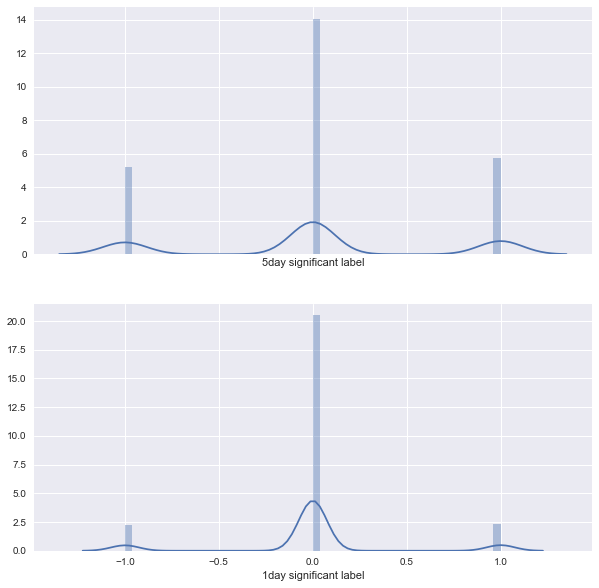

In [18]:
f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
sns.distplot(merged_data['5day significant label'], ax=ax1)
sns.distplot(merged_data['1day significant label'], ax=ax2)

In [19]:
merged_data['5day significant label'].value_counts()

 0    3287
 1    1347
-1    1213
Name: 5day significant label, dtype: int64

In [20]:
X = merged_data['rawText']
y = merged_data['5day significant label'] + 1

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and DNN model

In [ ]:
tfidf = TfidfVectorizer(max_df=0.3, min_df=5, ngram_range=(1,3), stop_words='english')

In [29]:
tfidf_vectors = tfidf.fit_transform(X_train)

In [30]:
classifier = learn.DNNClassifier(hidden_units=[20, 40, 20], n_classes=3, 
                                 feature_columns=[tf.contrib.layers.real_valued_column("", dimension=tfidf_vectors.shape[1])])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_master': '', '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_is_chief': True, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_environment': 'local', '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_task_type': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_task_id': 0, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000029E24953470>}


In [31]:
classifier.fit(tfidf_vectors.todense(), y_train, batch_size=20, steps=600)

MemoryError: 

In [ ]:
y_predicted = list(classifier.predict(tfidf.transform(X_test).todense()))

#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [ ]:
cm = confusion_matrix(y_test, y_predicted)

In [ ]:
sns.heatmap(cm, cmap='magma', annot=True, xticklabels=['-1', '0', '1'], yticklabels=['-1', '0', '1'])

In [ ]:
cr = classification_report(y_test, y_predicted)
print(cr)

In [ ]:
accuracy_score(y_test, y_predicted)

# Playground

In [ ]:
indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names()
top_n = 10
top_features = [features[i] for i in indices[:top_n]]
print(top_features)